# Activity Tutorial

This tutorial provides a comprehensive introduction to computing chemical activity in aerosol particles using Particula's activity strategies. We'll cover ideal activity (Raoult's Law), non-ideal activity using the BAT model, kappa parameter activity for hygroscopic growth, and integration with equilibria calculations.

## What is Activity?

Chemical activity is a measure of the "effective concentration" of a species that determines its thermodynamic behavior. In aerosol systems:

- **Activity controls partitioning**: Species with higher activity in the condensed phase tend to evaporate
- **Water activity determines hygroscopic growth**: Low water activity drives water uptake from the gas phase
- **Non-ideality matters**: Real mixtures deviate from ideal behavior, especially organic-water systems

## Notebook Structure

1. **Ideal Activity** - Raoult's Law and ideal mixing
2. **Non-Ideal Activity (BAT)** - Binary Activity Thermodynamic model
3. **Kappa Hygroscopic Parameter** - Water activity from kappa values
4. **Integration with Equilibria** - Liquid-vapor partitioning

> **Note**: This tutorial complements the existing [Activity Tutorial](../Particle_Phase/Notebooks/Activity_Tutorial.ipynb) which demonstrates Strategy, Builder, and Factory patterns in detail.

In [1]:
# Install particula if needed (uncomment for Colab)
# !pip install particula --quiet

import matplotlib.pyplot as plt
import numpy as np
import particula as par

# Set plot style
plt.style.use("seaborn-v0_8-whitegrid")

---
## 1. Ideal Activity (Raoult's Law)

For ideal solutions, activity equals the mole fraction of the species. This is known as **Raoult's Law**:

$$a_i = x_i$$

where $a_i$ is the activity and $x_i$ is the mole fraction of species $i$.

The partial pressure is:

$$p_i = a_i \cdot p_i^{\circ} = x_i \cdot p_i^{\circ}$$

### 1.1 Creating an Ideal Activity Strategy

In [2]:
# Define species: water and organic
molar_mass = np.array([18.015e-3, 200.0e-3])  # kg/mol

# Create ideal molar activity strategy
ideal_strategy = par.particles.ActivityIdealMolar(
    molar_mass=molar_mass,
)

print(f"Strategy: {type(ideal_strategy).__name__}")
print(f"Molar masses: {ideal_strategy.molar_mass * 1e3} g/mol")

Strategy: ActivityIdealMolar
Molar masses: [ 18.015 200.   ] g/mol


### 1.2 Computing Activity from Mass Concentrations

In [3]:
# Define mass concentrations (50% water, 50% organic by mass)
mass = np.array([0.5e-9, 0.5e-9])  # kg/m^3

# Compute activity
activity = ideal_strategy.activity(mass_concentration=mass)

print(f"Mass concentrations: {mass * 1e9} ng/m^3")
print(f"Activity values: water={activity[0]:.4f}, organic={activity[1]:.4f}")

# Verify activity equals mole fraction
moles = mass / molar_mass
mole_fractions = moles / np.sum(moles)
print(
    f"Mole fractions: water={mole_fractions[0]:.4f}, organic={mole_fractions[1]:.4f}"
)

Mass concentrations: [0.5 0.5] ng/m^3
Activity values: water=0.9174, organic=0.0826
Mole fractions: water=0.9174, organic=0.0826


### 1.3 Visualization: Activity vs Composition

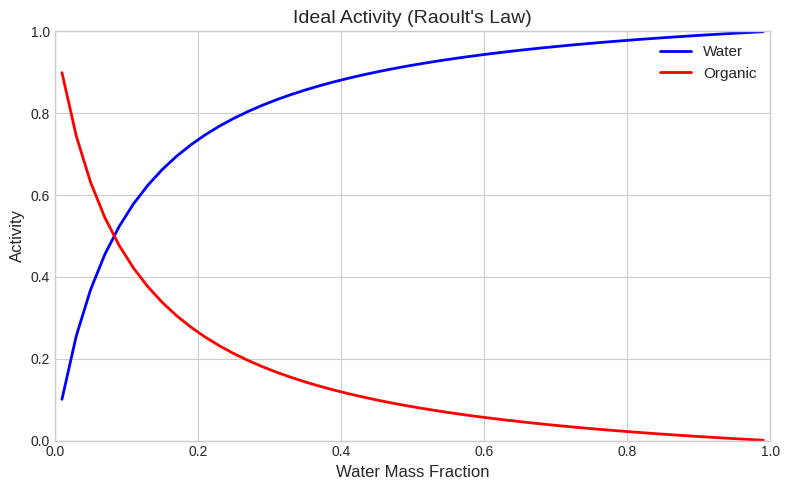

In [4]:
# Calculate activity across composition range
water_fractions = np.linspace(0.01, 0.99, 50)
water_activities = []
organic_activities = []

for wf in water_fractions:
    mass = np.array([wf, 1.0 - wf]) * 1e-9
    activity = ideal_strategy.activity(mass_concentration=mass)
    water_activities.append(activity[0])
    organic_activities.append(activity[1])

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(water_fractions, water_activities, "b-", linewidth=2, label="Water")
ax.plot(water_fractions, organic_activities, "r-", linewidth=2, label="Organic")
ax.set_xlabel("Water Mass Fraction", fontsize=12)
ax.set_ylabel("Activity", fontsize=12)
ax.set_title("Ideal Activity (Raoult's Law)", fontsize=14)
ax.legend(fontsize=11)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

Note that water activity is not linear with mass fraction due to the different molar masses. Even at 50% water by mass, water activity is high (~0.92) because water has many more moles than the heavy organic.

---
## 2. Non-Ideal Activity (BAT Model)

The **Binary Activity Thermodynamic (BAT)** model accounts for non-ideal interactions between water and organic species. The model uses the organic's oxygen-to-carbon (O:C) ratio to predict activity coefficients.

For non-ideal mixtures:

$$a_i = \gamma_i \cdot x_i$$

where $\gamma_i$ is the activity coefficient (deviates from 1 for non-ideal behavior).

### 2.1 Creating a BAT Activity Strategy

In [5]:
# Create non-ideal activity strategy using builder
bat_strategy = (
    par.particles.ActivityNonIdealBinaryBuilder()
    .set_molar_mass(200.0, "g/mol")  # automatic unit conversion
    .set_oxygen2carbon(0.4)  # O:C ratio
    .set_density(1200.0, "kg/m^3")
    .build()
)

print(f"Strategy: {type(bat_strategy).__name__}")
print(f"Organic O:C ratio: {bat_strategy.oxygen2carbon}")

Strategy: ActivityNonIdealBinary
Organic O:C ratio: 0.4


### 2.2 Comparing Ideal vs Non-Ideal Activity

In [6]:
# Compute activities at 50% water
mass = np.array([0.5, 0.5]) * 1e-9  # kg/m^3

ideal_activity = ideal_strategy.activity(mass_concentration=mass)
# Note: BAT model returns only organic activity (scalar)
bat_organic_activity = bat_strategy.activity(mass_concentration=mass)

print("At 50% water by mass:")
print(
    f"  Ideal activity:     water={ideal_activity[0]:.4f}, organic={ideal_activity[1]:.4f}"
)
print(f"  Non-ideal (BAT):    organic={bat_organic_activity:.4f}")

# Compute activity coefficient for organic
moles = mass / np.array([18.015e-3, 200.0e-3])
mole_frac = moles / np.sum(moles)
gamma_organic = bat_organic_activity / mole_frac[1]
print(f"\n  Organic activity coefficient: gamma={gamma_organic:.4f}")

At 50% water by mass:
  Ideal activity:     water=0.9174, organic=0.0826
  Non-ideal (BAT):    organic=0.1340

  Organic activity coefficient: gamma=1.6214


### 2.3 Visualization: Ideal vs Non-Ideal Comparison

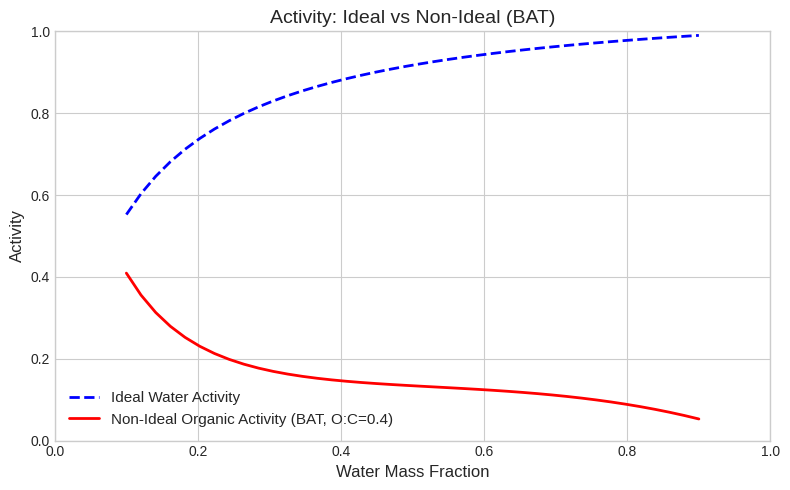

In [7]:
# Calculate activities across composition range
water_fractions = np.linspace(0.1, 0.9, 40)

ideal_water = []
bat_organic = []

for wf in water_fractions:
    mass = np.array([wf, 1.0 - wf]) * 1e-9
    ideal_water.append(ideal_strategy.activity(mass_concentration=mass)[0])
    # BAT returns organic activity (scalar), not water activity
    bat_organic.append(float(bat_strategy.activity(mass_concentration=mass)))

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(
    water_fractions,
    ideal_water,
    "b--",
    linewidth=2,
    label="Ideal Water Activity",
)
ax.plot(
    water_fractions,
    bat_organic,
    "r-",
    linewidth=2,
    label="Non-Ideal Organic Activity (BAT, O:C=0.4)",
)
ax.set_xlabel("Water Mass Fraction", fontsize=12)
ax.set_ylabel("Activity", fontsize=12)
ax.set_title("Activity: Ideal vs Non-Ideal (BAT)", fontsize=14)
ax.legend(fontsize=11)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

### 2.4 Effect of O:C Ratio on Non-Ideality

/tmp/ipykernel_1838232/4287444488.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("viridis")(np.linspace(0.2, 0.8, len(o2c_values)))


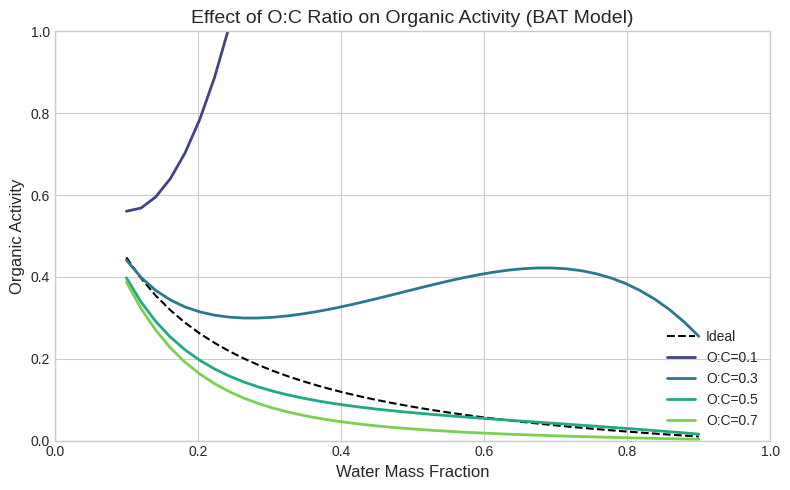

In [8]:
# Test different O:C ratios
o2c_values = [0.1, 0.3, 0.5, 0.7]
water_fractions = np.linspace(0.1, 0.9, 40)

fig, ax = plt.subplots(figsize=(8, 5))

# Ideal reference (organic activity)
ideal_organic = [
    ideal_strategy.activity(mass_concentration=np.array([wf, 1 - wf]) * 1e-9)[1]
    for wf in water_fractions
]
ax.plot(water_fractions, ideal_organic, "k--", linewidth=1.5, label="Ideal")

# BAT at different O:C ratios (returns organic activity)
colors = plt.cm.get_cmap("viridis")(np.linspace(0.2, 0.8, len(o2c_values)))
for o2c, color in zip(o2c_values, colors):
    strat = (
        par.particles.ActivityNonIdealBinaryBuilder()
        .set_molar_mass(200.0, "g/mol")
        .set_oxygen2carbon(o2c)
        .set_density(1200.0, "kg/m^3")
        .build()
    )
    bat_organic = [
        float(strat.activity(mass_concentration=np.array([wf, 1 - wf]) * 1e-9))
        for wf in water_fractions
    ]
    ax.plot(
        water_fractions,
        bat_organic,
        "-",
        color=color,
        linewidth=2,
        label=f"O:C={o2c}",
    )

ax.set_xlabel("Water Mass Fraction", fontsize=12)
ax.set_ylabel("Organic Activity", fontsize=12)
ax.set_title("Effect of O:C Ratio on Organic Activity (BAT Model)", fontsize=14)
ax.legend(fontsize=10, loc="lower right")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

Higher O:C ratios (more polar organics) show behavior closer to ideal, while low O:C ratios (hydrophobic organics) show stronger non-ideality.

---
## 3. Kappa Hygroscopic Parameter

The **kappa parameter** ($\kappa$) provides a single-parameter representation of hygroscopicity from the Kohler equation. It relates the dry particle volume to water activity:

$$a_w = \frac{V_w}{V_w + \kappa V_s}$$

where $V_w$ is water volume and $V_s$ is solute volume.

Common kappa values:
- Ammonium sulfate: $\kappa \approx 0.61$
- Sodium chloride: $\kappa \approx 1.28$
- Organics: $\kappa \approx 0.1$ (variable)

### 3.1 Creating a Kappa Parameter Strategy

In [9]:
# Water + ammonium sulfate system
kappa_strategy = par.particles.ActivityKappaParameter(
    kappa=np.array([0.0, 0.61]),  # water, (NH4)2SO4
    density=np.array([1000.0, 1770.0]),  # kg/m^3
    molar_mass=np.array([18.015e-3, 132.14e-3]),  # kg/mol
    water_index=0,
)

print(f"Strategy: {type(kappa_strategy).__name__}")
print(f"Kappa values: {kappa_strategy.kappa}")

Strategy: ActivityKappaParameter
Kappa values: [0.   0.61]


### 3.2 Water Activity at Different Compositions

In [10]:
# Compute water activity at different water contents
print("Water Activity for Water + Ammonium Sulfate:")
print("Water Fraction | Water Activity")
print("-" * 35)

for water_frac in [0.3, 0.5, 0.7, 0.9]:
    mass = np.array([water_frac, 1.0 - water_frac]) * 1e-9
    activity = kappa_strategy.activity(mass_concentration=mass)
    print(f"    {water_frac:.1f}        |     {activity[0]:.4f}")

Water Activity for Water + Ammonium Sulfate:
Water Fraction | Water Activity
-----------------------------------
    0.3        |     0.5543
    0.5        |     0.7437
    0.7        |     0.8713
    0.9        |     0.9631


### 3.3 Visualization: Kappa Activity vs Composition

/tmp/ipykernel_1838232/619938268.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("plasma")(np.linspace(0.2, 0.8, len(kappa_values)))


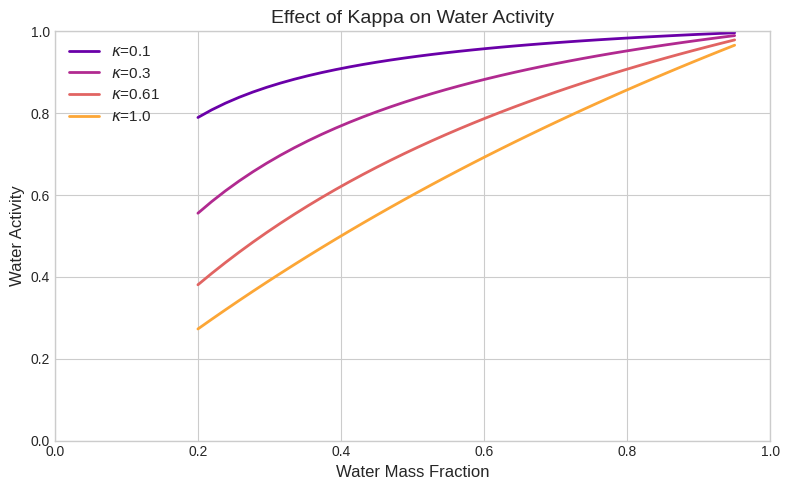

In [11]:
# Compare different kappa values
kappa_values = [0.1, 0.3, 0.61, 1.0]
water_fractions = np.linspace(0.2, 0.95, 40)

fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.cm.get_cmap("plasma")(np.linspace(0.2, 0.8, len(kappa_values)))
for kappa, color in zip(kappa_values, colors):
    strat = par.particles.ActivityKappaParameter(
        kappa=np.array([0.0, kappa]),
        density=np.array([1000.0, 1500.0]),
        molar_mass=np.array([18.015e-3, 100.0e-3]),
        water_index=0,
    )
    water_activities = [
        strat.activity(mass_concentration=np.array([wf, 1 - wf]) * 1e-9)[0]
        for wf in water_fractions
    ]
    ax.plot(
        water_fractions,
        water_activities,
        "-",
        color=color,
        linewidth=2,
        label=f"$\\kappa$={kappa}",
    )

ax.set_xlabel("Water Mass Fraction", fontsize=12)
ax.set_ylabel("Water Activity", fontsize=12)
ax.set_title("Effect of Kappa on Water Activity", fontsize=14)
ax.legend(fontsize=11)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

Higher kappa values (more hygroscopic) result in lower water activity at the same water content, driving more water uptake to reach equilibrium.

---
## 4. Integration with Equilibria

Activity calculations integrate with liquid-vapor partitioning to determine how organic species distribute between gas and particle phases.

### 4.1 Liquid-Vapor Partitioning Strategy

In [12]:
# Create partitioning strategy at 75% RH
partitioning = par.equilibria.LiquidVaporPartitioningStrategy(
    water_activity=0.75,
)

print(f"Strategy: {type(partitioning).__name__}")
print(f"Target water activity: {partitioning.water_activity}")

Strategy: LiquidVaporPartitioningStrategy
Target water activity: 0.75


### 4.2 Solving for Equilibrium

In [13]:
# Define organic species (3 volatility classes)
c_star_j_dry = np.array([1e-6, 1e-4, 1e-2])  # saturation conc (ug/m^3)
concentration_organic = np.array([1.0, 5.0, 10.0])  # ug/m^3
molar_mass = np.array([200.0, 200.0, 200.0])  # g/mol
o2c_ratio = np.array([0.2, 0.3, 0.5])
density = np.array([1200.0, 1200.0, 1200.0])  # kg/m^3

# Solve for equilibrium
result = partitioning.solve(
    c_star_j_dry=c_star_j_dry,
    concentration_organic_matter=concentration_organic,
    molar_mass=molar_mass,
    oxygen2carbon=o2c_ratio,
    density=density,
)

print("=== Equilibrium Results ===")
print(f"Partition coefficients: {result.partition_coefficients}")
print(f"Alpha phase water: {result.alpha_phase.water_concentration:.2f} ug/m^3")
print(f"Optimization error: {result.error:.2e}")

=== Equilibrium Results ===
Partition coefficients: [0.99999998 0.99999838 0.9998916 ]
Alpha phase water: 4.51 ug/m^3
Optimization error: 5.57e-14


### 4.3 Effect of RH on Partitioning

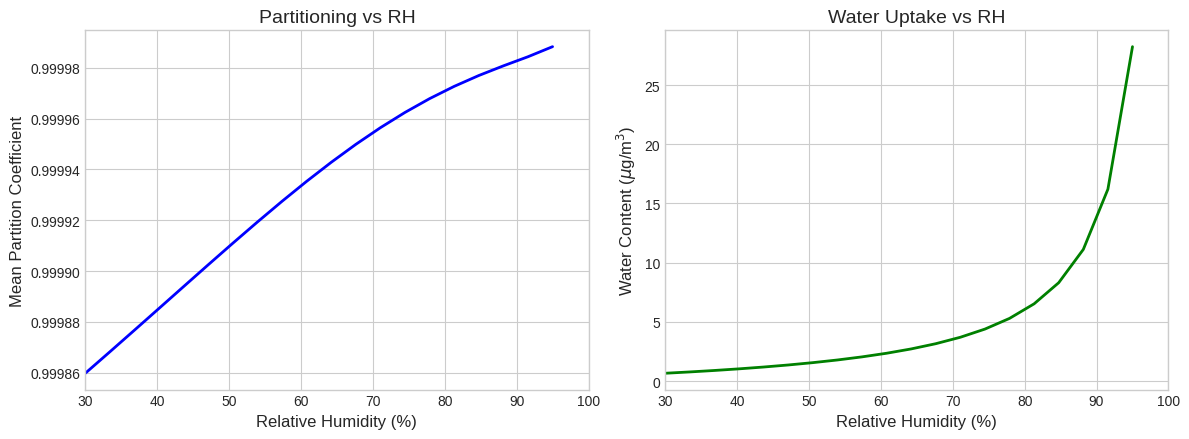

In [14]:
# Calculate partitioning at different RH values
rh_values = np.linspace(0.3, 0.95, 20)
mean_partitions = []
water_contents = []

for rh in rh_values:
    strat = par.equilibria.LiquidVaporPartitioningStrategy(water_activity=rh)
    res = strat.solve(
        c_star_j_dry=c_star_j_dry,
        concentration_organic_matter=concentration_organic,
        molar_mass=molar_mass,
        oxygen2carbon=o2c_ratio,
        density=density,
    )
    mean_partitions.append(np.mean(res.partition_coefficients))
    water_contents.append(res.alpha_phase.water_concentration)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

ax1.plot(rh_values * 100, mean_partitions, "b-", linewidth=2)
ax1.set_xlabel("Relative Humidity (%)", fontsize=12)
ax1.set_ylabel("Mean Partition Coefficient", fontsize=12)
ax1.set_title("Partitioning vs RH", fontsize=14)
ax1.set_xlim(30, 100)

ax2.plot(rh_values * 100, water_contents, "g-", linewidth=2)
ax2.set_xlabel("Relative Humidity (%)", fontsize=12)
ax2.set_ylabel("Water Content ($\\mu$g/m$^3$)", fontsize=12)
ax2.set_title("Water Uptake vs RH", fontsize=14)
ax2.set_xlim(30, 100)

plt.tight_layout()
plt.show()

---
## Summary

In this tutorial, we covered:

1. **Ideal Activity (Raoult's Law)**: Activity equals mole fraction for ideal mixtures
2. **Non-Ideal Activity (BAT)**: Activity coefficients deviate from 1, especially for low O:C organics
3. **Kappa Parameter**: Single-parameter representation of hygroscopicity for water activity
4. **Equilibria Integration**: Activity determines gas-particle partitioning

### Key Takeaways

- Choose your activity model based on your system:
  - **Simple mixtures**: `ActivityIdealMolar`
  - **Hygroscopic aerosols**: `ActivityKappaParameter`
  - **Organic-water mixtures**: `ActivityNonIdealBinary` (BAT)
- Non-ideality is important for accurate aerosol thermodynamics
- Higher RH increases water uptake and organic partitioning

### Next Steps

- [Activity Theory](../../Theory/Activity_Calculations/activity_theory.md) - Mathematical foundations
- [Equilibria Theory](../../Theory/Activity_Calculations/equilibria_theory.md) - Partitioning equations
- [Activity System Feature Guide](../../Features/activity_system.md) - Full API documentation